# TP Optimisation II:  A simple neural network 

### Nom(s): ELFTOUH
### Prénom(s): Salmane
### Groupe: B1

## Useful packages

In [28]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Loading of the train and test data

In [38]:
#
# Load train data
#
Xtrain = np.load('train-images.npy')
Xtrain = np.array([x.ravel()/255 for x in Xtrain])
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
Ytrain = np.load('train-labels.npy')
targets_train = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytrain:
    v      = np.zeros((10,1))
    v[lab] = 1
    targets_train+=[np.array(v)]

#
# Load test data
#
Xtest        = np.load('t10k-images.npy')
Xtest        = np.array([x.ravel()/255 for x in Xtest])
Xtest        = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)
Ytest        = np.load('t10k-labels.npy')
targets_test = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytest:
    v = np.zeros((10,1))
    v[lab]=1
    targets_test+=[np.array(v)]
#
# Outputs
#
print('There are ',Xtrain.shape[0],'images in the train set')
print('There are ',Xtest.shape[0],'images in the test set')

There are  60000 images in the train set
There are  10000 images in the test set


## Definition of the activation function

 The activation function defines the output of a node given a set of inputs. We use the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> function defined by
 
 $$\sigma_{\alpha} : \mathbb{R}^p\rightarrow [0,1]^p, \quad \mbox{ s.t.} \quad[\sigma_{\alpha}(x)]_i=\frac{e^{x_i+\alpha_i}}{\displaystyle{\sum_{j=1}^{p}e^{x_j+\alpha_j}}}\quad \forall i=1:p. $$  


In [39]:
#
# Nonlinear activation function
#
def softmax(x,alpha):
    """
    Softmax unit activation function 
    x    : Numpy array
    alpha: Numpy array
    """ 
    S=np.sum(np.exp(np.add(x,alpha)))
    value= np.exp(np.add(x,alpha))/S
    
    return value

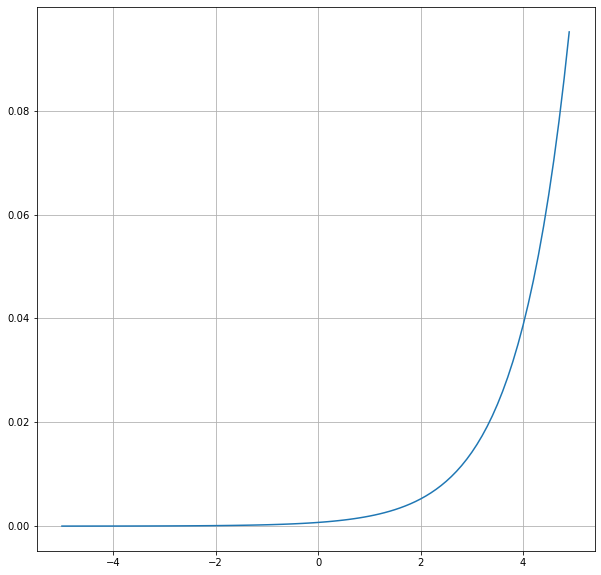

In [40]:
#
# Example of a plot of the activation function
#
t     = np.arange(-5,5,0.1)
alpha = [0.] #np.arange(-50,50,1)
plt.figure(figsize=(10,10))
plt.plot(t,softmax(t,alpha))
plt.grid(True)
plt.show()

## Definition of a simple neural network

We use a one-layer fully-connected neural network with the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> activation function.


In [41]:
def NN(x,W):
    """
    # One-layer fully connected neural network
    # x: image, i.e. 784x1 vector (28x28)
    # W: weight matrices of shape 10x784   
    """
    y=W.dot(x)
    pred=softmax(y,-np.max(y))
    
    return pred

## Definition of the loss function

The loss function is the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross-entropy</a> defined by 

$$J(W)=-\sum_{i=1}^N p_i \log(q_i(W)),$$ where $N$ is the number of classes, $(p_i)_{i=1:N}$ are the probabilities of  a data from the training set to belong to a class (0 or 1 because the labels are known), and $(q_i(W))_{i=1:N}$ are the predicted probabilities from the model

$$\forall i=1:N, \quad q_i(W)=[\sigma_{\alpha}(Wx)]_i.$$

In [42]:
#
# Loss function = Cross-entropy
#
def cross_entropy(s,target,x):
    """
    s:   predicted probabilities (q(W))
    target: probabilities (p)
    x:      image 
    """ 
   
    ce = -target.T.dot(np.log(s))
    #
    # gradient of the cross-entropy
    #
    u    =  np.ones((s.shape[0],1))
    g    = (-u.T.dot(target)*(s.dot(x.T))+target*x.T)
    grad = -g.reshape(x.shape[0]*target.shape[0],1)
    
    return ce,grad
#
# Main function 
#
def f(W,x,target):
    """
    W:      weights
    target: probabilities (p)
    x:      image
    """
    #
    # TO DO: return ce, grad, pred (cross_entropy, gradient, predicted probabilities)
    #
    pred=NN(x,W)
    ce,grad=cross_entropy(pred,target,x)
    
    return ce,grad,pred

In [34]:
#
# Test information on the gradient with calls of f
#

# Define weight matrices
W      = np.random.rand(10,Xtrain.shape[1])
eps    = 1e-8
d      = np.random.rand(10,Xtrain.shape[1])
Wtilde = W+eps*d

# Retrieve the information on the gradients
res    = (f(Wtilde,Xtrain[0],targets_train[0])[0]-f(W,Xtrain[0],targets_train[0])[0])/eps
print(res)

g      = f(W,Xtrain[0],targets_train[0])[1]
print(g.T.dot(d.reshape(7840,1)))

[[5.27114672]]
[[5.27114749]]


## Generating batches 

In [50]:
#
# Function to create batches of samples to be used later in the training phase
#
def create_batches(x,bs):
    """
    x : set to be considered (array)
    bs: batch size (scalar)
    """
    batches = []
    ind     = np.arange(x.shape[0]) # x.shape[0]= nombre d'images
    random.shuffle(ind)
    nbatch  = ind.shape[0]//bs
    rest    = ind.shape[0]%bs
    
    for n in range(nbatch):
        batches +=[ind[bs*n:bs*(n+1)]]
    
    # Put the remaining elements in a last batch
    if rest !=0:        
        batches += [ind[-rest:]]
        
    return batches

## Training of the neural network

In [61]:
history    = {}
eta        = 1e-4 # learning rate
momentum   = 0.   # momemtum factor
N_EPOCHS   = 10  
BatchSizes = [10000,1024,256] # try different batch sizes for the analysis

for bs in BatchSizes:
    #
    # Sensitivity to the batch size to be investigated in the analysis
    #
    print('batch size=',bs)
    
    history[bs]={'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}
    
    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])
    
    for n in range(N_EPOCHS):
        # Minimization of the loss function
        
        Batches=create_batches(Xtrain,bs) #On crée différents lots d'images pour l'entrainnement 
        #(Batches contient une liste de liste d'indices d'images de Xtrain chargée précédemment)
        
        #pour chaque lot:
        for batch in Batches:
            sum_grad=0
            ce_train=0
            ce_test=0
            
            train_acc=0 #compteur des prédictions justes
            test_acc=0
            
            #pour chaque indice du lot (pour chaque image)
            for ind_x in batch :
                x=Xtrain[ind_x] # x est l'image d'indice ind_x
                target=targets_train[ind_x] # target est le label de l'image (le chiffre marqué sur l'image)
                
                ce,grad,pred= f(w,x,target) #On calcul la prédiction du réseau de neurones 
                #(pred est un vecteur de 10 composantes représentant la probabilité d'appartenance de 
                #l'image à chaque classe)
                
                sum_grad+=grad
                ce_train+=ce
                
                #on prend l'indice de la probabilité maximale (donc le chiffre prédit)
                prediction=list(pred).index(np.max(pred))
                true= list(target).index(1)# le label de l'image
                
                if prediction==true: #si la prédiction est juste (prediction=le label de l'image) 
                    train_acc+=1
            
            #on enregistre le pourcentage de bonne prédiction pour ce lot d'image
            history[bs]['train acc']+=[train_acc/batch.shape[0]]
            
            #on enregistre la valeur moyenne de la fonction de perte pour ce lot d'images
            history[bs]['train loss']+=[ce_train[0][0]/batch.shape[0]] 
            
            sum_grad=sum_grad.reshape(w.shape[0],w.shape[1])
            w=w-eta*sum_grad #on recalcule w dans "le sens inverse du gradient" (algorithme du gradient)
            #pour minimiser la fonction perte
            
            
        #pour chaque image des Xtest     
        for ind_test,x in enumerate(Xtest):
            lab= targets_test[ind_test] #le label de l'image (pour le comparer à la prédiction )
            ce,_,pred=f(w,x,lab)
            ce_test+=ce
            #on prend l'indice de la probabilité maximale (donc le chiffre prédit)
            prediction = list(pred).index(np.max(pred))
            true = list(lab).index(1)#le label de l'image
            
            if prediction==true: #si la prédiction est juste
                test_acc+=1
        
        #on enregistre le pourcentage de bonne prédiction pour les images de test
        history[bs]['test acc']+=[test_acc/Xtest.shape[0]]
        
        #on enregistre la valeur moyenne de la fonction de perte pour les images de test
        history[bs]['test loss']+=[ce_test[0][0]/Xtest.shape[0]]
            
        
        print('Epoch number :', n+1,'test accuracy:',history[bs]['test acc'][n+1],'test loss',history[bs]['test loss'][n+1])
        

    print('\n')            

batch size= 10000
Epoch number : 1 test accuracy: 0.6003 test loss 1.4612299785087548
Epoch number : 2 test accuracy: 0.7196 test loss 0.8753414581705962
Epoch number : 3 test accuracy: 0.7668 test loss 0.7264941238175944
Epoch number : 4 test accuracy: 0.8251 test loss 0.5637665054128963
Epoch number : 5 test accuracy: 0.8393 test loss 0.5139596212973558
Epoch number : 6 test accuracy: 0.8497 test loss 0.4859937296680424
Epoch number : 7 test accuracy: 0.8561 test loss 0.4631832136822129
Epoch number : 8 test accuracy: 0.8637 test loss 0.4476412167992771
Epoch number : 9 test accuracy: 0.8674 test loss 0.43509165051099336
Epoch number : 10 test accuracy: 0.8706 test loss 0.42360866894688426


batch size= 1024
Epoch number : 1 test accuracy: 0.6476 test loss 1.0712869891934647
Epoch number : 2 test accuracy: 0.7623 test loss 0.7460243474146456
Epoch number : 3 test accuracy: 0.8022 test loss 0.6220812550319862
Epoch number : 4 test accuracy: 0.8261 test loss 0.556978239498325
Epoch num

## Plots of the evolution of the loss function

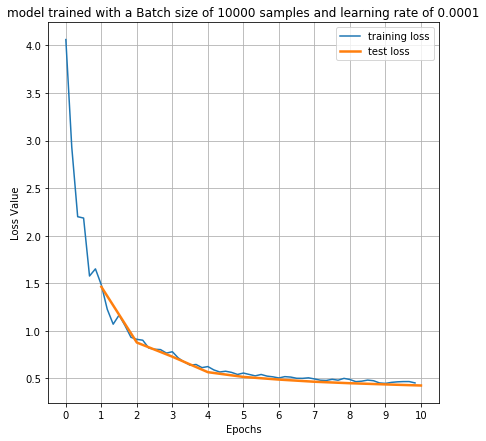

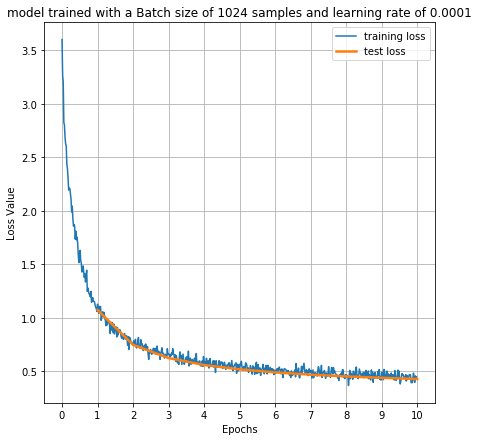

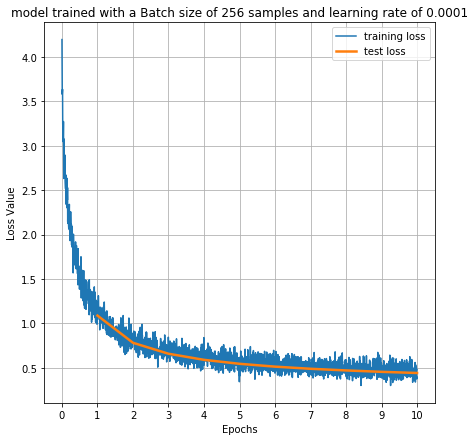

In [62]:
for bs in BatchSizes:
       
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    E  = [n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[bs]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.show()

## Plots of the evolution of the accuracy

10000
6


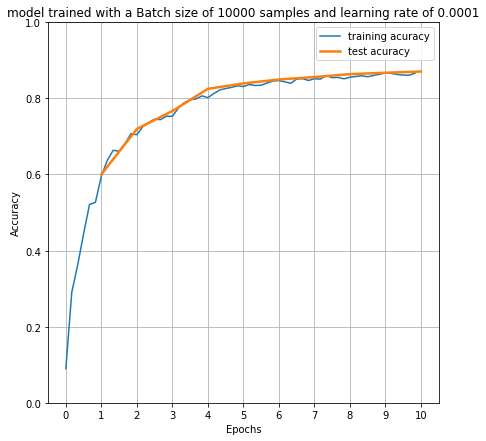

1024
59


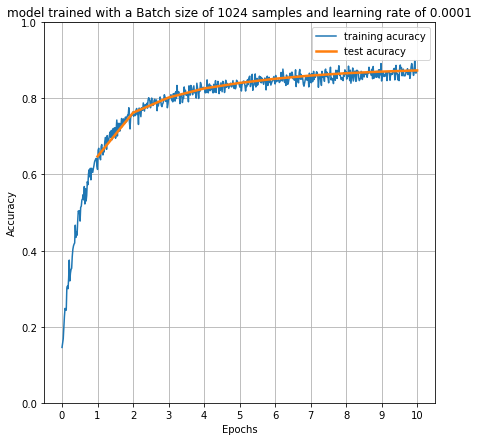

256
235


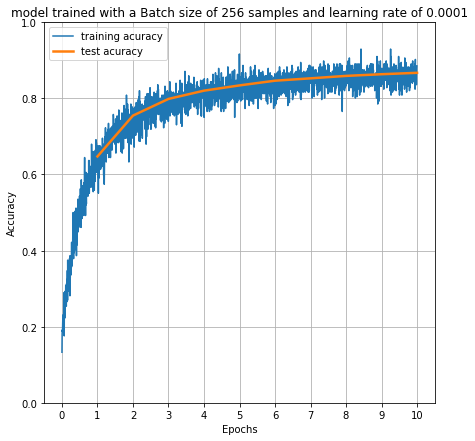

In [63]:
for bs in BatchSizes:
    print(bs)   
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    print(n_batch)
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[bs]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()

## Analysis of the results

Please provide your comments on the sensitivity of the results to the parameters involved in the learning process (batch size, learning rate, momentum).

### Your comments: